In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from imblearn.over_sampling import ADASYN
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive')

from binary_load import binary_load_dataset

from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers as Layer
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.regularizers import L1L2
from timeit import default_timer as timer

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
csv_loca = "star.csv"
TEST_SIZE = 0.2
VAL_SIZE = 0.2
RANDOM_STATE = 42

In [35]:
class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")
        self.starttime = timer()

    def on_train_end(self, logs=None):
        print("End of training, took {} seconds".format(timer()-self.starttime))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
          print("Epoch is {} and {} seconds passed".format(epoch, timer()-self.starttime))

In [22]:
def modelling(nodes1 = 8, nodes2= 6, nodes3 = 4, drop_rate= 0.2, activation= 'relu'):
  # 모델 만들기
  # 뉴런의 개수는 input과 output 사이의 숫자를 넣으라고 한다. --> 사용, 왜냐하면 시간이 적게 걸려서
  # 뉴런의 개수는 input의 2/3 정도 넣라고 한다.
  # 뉴런의 개수는 input의 두배보다는 적게 넣라고 한다.
  regularizer = L1L2(l1=0.001, l2=0.001)

  model = Sequential([Layer.Dense(12, input_shape=(8,))])
  model.add(Layer.Dense(nodes1, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(nodes2, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(nodes3, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(1, activation = 'sigmoid'))

  # metrics에는 1이 나오는 recall 이랑 acc만 중요하다.
  metrics = [
      Recall(name = 'recall'),
      Precision(name = 'precision'),
      BinaryAccuracy(name = 'binary accuracy') # Accuracy를 사용 안 하는 이유는 Accuracy가 이상하세 나왔기 때문.
  ]

  model.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics = metrics)

  return model

In [23]:
X_train, X_val, X_test, y_train, y_val, y_test = binary_load_dataset(csv_loca, TEST_SIZE, VAL_SIZE, RANDOM_STATE)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11454, 8), (11454,), (2864, 8), (2864,), (3580, 8), (3580,))

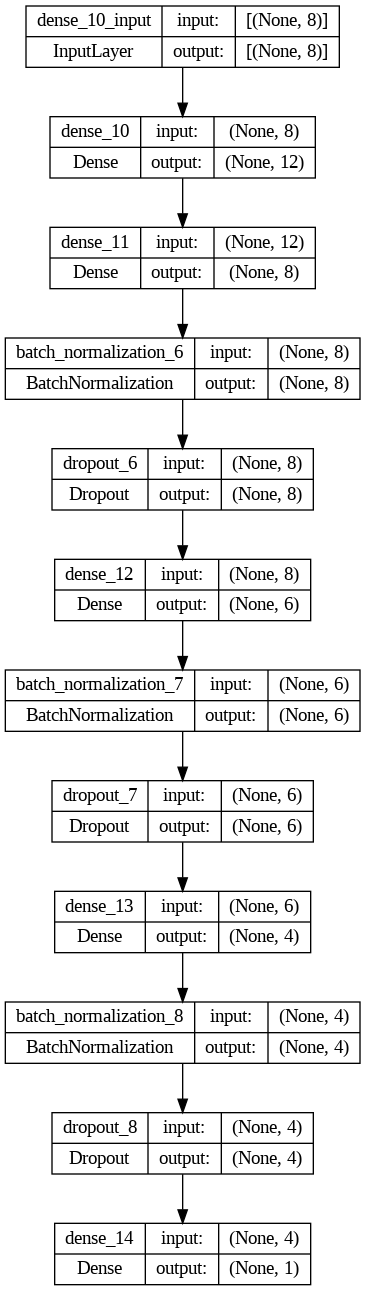

In [24]:
model = modelling()
keras.utils.plot_model(model, show_shapes=True)

In [36]:
check_path = 'model.h5'

callback = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200),
    tf.keras.callbacks.ModelCheckpoint(filepath=check_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=200, min_lr=0.001),
    TimingCallback()
]

In [37]:
model.fit(X_train, y_train, batch_size= 1024, epochs= 1000,  validation_data=(X_val, y_val), callbacks=callback,verbose = 0)

Starting training
Epoch is 0 and 0.19433932500010087 seconds passed
Epoch is 10 and 1.3960791370000152 seconds passed
Epoch is 20 and 2.5538953400000537 seconds passed
Epoch is 30 and 3.7216697680000834 seconds passed
Epoch is 40 and 4.911153280000008 seconds passed
Epoch is 50 and 6.054178519000061 seconds passed
Epoch is 60 and 7.535992570999952 seconds passed
Epoch is 70 and 9.183027360000096 seconds passed
Epoch is 80 and 10.434897882000087 seconds passed
Epoch is 90 and 11.571049002000109 seconds passed
Epoch is 100 and 12.70598088099996 seconds passed
Epoch is 110 and 13.852100031999953 seconds passed
Epoch is 120 and 15.035624559000098 seconds passed
Epoch is 130 and 16.198757204999993 seconds passed
Epoch is 140 and 17.352125029000035 seconds passed
Epoch is 150 and 18.557140920999927 seconds passed
Epoch is 160 and 19.76952241799995 seconds passed
Epoch is 170 and 21.37229689500009 seconds passed
Epoch is 180 and 22.96049189600012 seconds passed
Epoch is 190 and 24.07036175300

In [38]:
model.load_weights(check_path)
results = model.evaluate(X_test, y_test)

112/112 [==============================] - 0s 3ms/step - loss: 0.0697 - recall: 0.8384 - precision: 0.9291 - binary accuracy: 0.9793


In [45]:
y_test_pred = model.predict(X_test)

y_test_pred = (y_test_pred > 0.35).astype(np.float32)

112/112 [==============================] - 0s 3ms/step


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

cm = pd.DataFrame(cm)
cm.columns = ['Predicted 0', 'Predicted 1']
cm.rename(index={0: "True 0", 1: "True 1"}, inplace = True)
cm

,Predicted 0,Predicted 1
True 0,3220,32
True 1,37,291


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.90      0.89      0.89       328

    accuracy                           0.98      3580
   macro avg       0.94      0.94      0.94      3580
weighted avg       0.98      0.98      0.98      3580

